# Introduction

The sky has fascinated humankind since the beginning of civilization. The thought of life beyond our planet has found its way into every facet of popular culture. From books to movies to magazines and more, the influence of the possibility of alien life and even first contact has captivated generations of people. Since the 1947 Roswell, New Mexico incident, there has been a piqued interest in alien sightings in recent years. Movies such as Close Encounters of the Third Kind, Alien, E.T. the Extra-Terrestrial, and countless more continue to entice viewers and question the probability of life beyond our planet.

The internet has enabled alien believers and conspiracy theorists to connect with each other and share evidence of what they believe proves extraterrestrial beings have visited our planet. One such group, the National UFO Reporting Center (NUFORC), currently based in a former nuclear missile site west of Spokane, Washington has meticulously cataloged Unidentified Flying Objects (UFO) sightings since its founding in 1974. They operate a 24-hour hotline for people to report any UFO activity that they have experienced.

We wanted to use the data the NUFORC has compiled over the years to see if we could find any trends or patterns within the data. We were curious if certain days of the year, times of day, or locations were more likely to have a reported UFO sighting. Additionally, because of its prevalence in the media, we wanted to determine if there was a correlation between sci-fi movie releases and UFO sightings. 

To accomplish our goals, we first contacted the director of NUFORC to gain permission to use their data; at first, he seemed open to allowing us to use their data (with some caveats: namely that we delete the data after), though he failed to respond to our follow up emails. Consequently, as we were still determined to use UFO data, we found a data set on Kaggle that someone had scraped from the NUFORC website which contained data from the early 1900s to 2013. We also collected movie data from The Movie Database on Science Fiction movie releases as well as from various government websites that documented state populations, unemployment rates, binge drinking prevalence, and opioid prescription rates.

To begin, we cleaned the UFO data to pertain only to sightings within the United States within the 14-year time period from 1999 to 2013. Then, we conducted summary statistics to determine basic metrics for the data. We found that the longest reported sightings were around 1.5 years and that the shortest reported sighting occurred for only 0.01 seconds. Afterward, we combined our various datasets in order to examine the data in a more detailed context. We looked at relationships between times of UFO sightings and frequencies, the prevalence of opioid prescriptions and binge drinking, as well as recent science fiction movie releases. While these reported UFO sightings have been meticulously documented by the NUFORC, we take all of our results with a grain of salt and cannot definitively state much beyond the correlations we discover. Our goal is not to determine whether these reported UFO sightings are direct evidence of extraterrestrial life; rather, we would like to point out common factors of reported sightings. 

In [3]:
# PREPARATION

# Dataframes
import pandas as pd

# Statistics
import numpy as np

# Datetime
import datetime
from datetime import datetime


# Regular Expressions
import re

# Words
import nltk
import nltk.corpus

# Plots
from plotnine import* 
import folium
import json
import os
from folium.plugins import MarkerCluster
MarkerCluster()
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot


import matplotlib.pyplot as plt

In [4]:
# For showing plots in notebook
plotly.offline.init_notebook_mode(connected = True)
# If the plot doesn't show up/just shows white space, this code entered into the terminal will help.
# jupyter notebook--NotebookApp.iopub_data_rate_limit=214748364


In [5]:
from nltk.corpus import wordnet

def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

lemmatizer = nltk.WordNetLemmatizer()

# Data Links

Age-adjusted prevalence of binge drinking among adults aged 18 years and older, by state, 
United States, 2015. Center for Disease Control and Prevention. https://www.cdc.gov/alcohol/data-table-text.htm#intensity 

Annual Unemployment Rates by State. Iowa State University. 
https://www.icip.iastate.edu/tables/employment/unemployment-states 

List of U.S. States by Population. Wikipedia. Accessed March 2019. 
https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population 

National UFO Reporting Center. Wikipedia. 
https://en.wikipedia.org/wiki/National_UFO_Reporting_Center 

The Movie db. https://www.themoviedb.org/ 

The National UFO Reporting Center. http://www.nuforc.org/index.html 

UFO Sightings Data set. Kaggle. https://www.kaggle.com/NUFORC/ufo-sightings 

Urbanization in the United States. Wikipedia
	https://en.wikipedia.org/wiki/Urbanization_in_the_United_States
    
U.S. State Prescribing Rates, 2010. Center for Disease Control and Prevention. 
https://www.cdc.gov/drugoverdose/maps/rxstate2010.html 



# Data Cleaning/Storage

First, we read in our main data set.

In [6]:
ufo = pd.read_csv('~/Desktop/ufo-sightings/ufo.csv') # Change for own filepath
ufo = pd.DataFrame(ufo)
ufo.dtypes# Columns 5 and 9 have mixed types warning [duration (seconds) and latitude]
len(ufo) # 80332 observations

/Users/Tim/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.



80332

In [7]:
# Drop all non-US countries
ufo = ufo[ufo["country"].str.contains('us',na = False)]
ufo = ufo[~ufo['state'].str.contains('pr',na = False)]

#ufo['datetime'] = dt.datetime.date(ufo['datetime'])
ufo['datetime'].dtype # It's an object, need to convert to string first? then onwards...
ufo['datetime'] = ufo['datetime'].astype(str)
# Have to change all 24:00 entries to 0:00
ufo['datetime'] = ufo['datetime'].str.replace('24:00', '0:00')
ufo['datetime'] = ufo['datetime'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y %H:%M') )
ufo['newtime'] = pd.DatetimeIndex(ufo.datetime).normalize()


In [8]:
# Remove all observations before 1999 and after 2013
ufo = ufo[(ufo['datetime'] > '1999-01-01') & (ufo['datetime'] < '2013-12-31')]
ufo = ufo.reset_index(drop = True)


* Cleaning specific rows

In [9]:
show = ufo[ufo['duration (seconds)'].str.contains('`') == True]
# Rows 19353 and 24450 have the strange symbol
ufo.drop(19353,inplace = True)
ufo.drop(24450,inplace = True)
# Had a lot of difficulties replacing the symbol, decided to just drop the two observations. 

In [10]:
# Fixing data types
ufo.dtypes # Need to change duration (seconds) and latitude
ufo['latitude'] = ufo['latitude'].astype(str).astype(float)
ufo['duration (seconds)'].replace('', np.nan, inplace=True)
ufo['duration (seconds)'] = ufo['duration (seconds)'].astype(str).astype(float)

# Capitalizing States
ufo['state'] = ufo['state'].astype(str)
ufo['state'] = ufo['state'].str.upper()


# Summary Statistics

In [11]:
len(ufo) # 53012
np.mean(ufo['duration (seconds)']) # Average duration of sightings are approximately 4141.51 seconds.
max(ufo['duration (seconds)']) # 52623200 seconds
min(ufo['duration (seconds)']) # 0.01 seconds

max(ufo['datetime']) # Dec 30 2013
min(ufo['datetime']) # Jan 1 1999


Timestamp('1999-01-01 02:30:00')

In [12]:
# Function that returns the top 5 (max) results for a dataframe and specific column.
def high5(df,column):
    '''Takes input of relevant data frame and column, returns the five highest results.'''
    new1 = df.sort_values(column, ascending=False)
    return new1.head(5)

high5(ufo,'duration (seconds)')
# We can see that some durations are for extremely long periods of time


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,newtime
45086,2002-08-24 01:00:00,englewood,FL,us,light,52623200.0,2 months,bright stars&#44 moving erratically&#44 over t...,8/28/2002,26.961667,-82.352778,2002-08-24
42100,2012-08-10 21:00:00,finley,WA,us,light,52623200.0,2 months,There have been several flying objects in a pe...,8/19/2012,46.154167,-119.032778,2012-08-10
46516,2008-08-03 21:00:00,virginia beach,VA,us,fireball,10526400.0,4 months,this object was very high up and emmited no so...,8/12/2008,36.852778,-75.978333,2008-08-03
32312,2012-06-15 21:00:00,huntington,NY,us,light,6312000.0,1-2 years,Strange lights in the sky that move and follow...,10/14/2013,40.868056,-73.426111,2012-06-15
15211,2009-12-31 23:30:00,livingston,LA,us,unknown,6312000.0,new years,The 12 UFO we seen brite yellow like a street ...,2/14/2010,30.501944,-90.747778,2009-12-31


# Analysis by Time of Day, Day, and Month

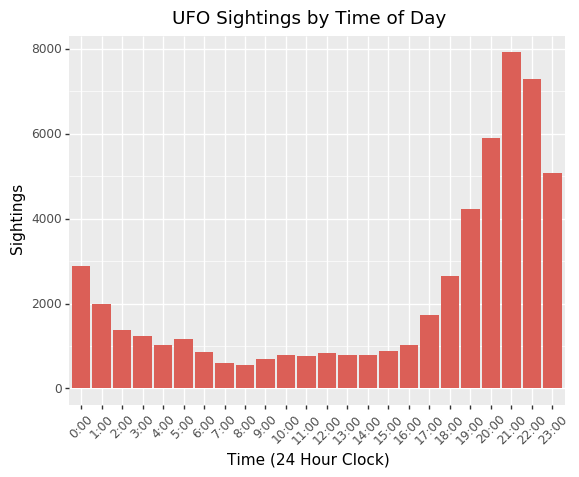

<ggplot: (-9223372029847253318)>

In [14]:
# By Hour of the day
day_time = ufo.copy()

day_time['time_hour'] = day_time['datetime'].dt.hour
day_time['time_hour'] = day_time['time_hour'].astype(str)
day_time['time_hour'] = day_time['time_hour']+':00'
hour_counts = pd.DataFrame(day_time['time_hour'].value_counts()).reset_index()
hour_counts.columns = [['hour','count']]
hour_counts.sort_values
hour_counts # Most common hour is 9 pm, 10pm, 8pm, 11pm, 7pm, 12am, 1am
# 6pm to 3am are the most common hours
# you could argue this is one most people are drunk 

(ggplot(hour_counts, aes(x = "hour",y = 'count',fill = '"#FF6666"'))+geom_bar(stat = 'identity',position = position_dodge)+
labs(title = "UFO Sightings by Time of Day", y = "Sightings"))+ guides(fill=False)+ scale_x_discrete(name = 'Time (24 Hour Clock)',limits=['0:00','1:00','2:00','3:00','4:00','5:00','6:00','7:00','8:00','9:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00'])+theme(axis_text_x = element_text(angle = 45))


We wanted to determine if certain months or days in the year saw an increase in UFO sightings when compared to other times of the year. All the graphs below encompass our 14 year period (1999-2013). The bar chart titled ‘UFO Sightings by Time of Day’ shows that reported sightings typically occur at later times when the night sky allows for greater visibility of illuminated objects, specifically from 7 pm to 1 am, with sightings highly reported between 9 pm and 11 pm. This is a time when most people are home and a time when people are more likely to be inebriated, which is a possible factor for reported sightings. 

In [15]:
day_time['month'] = day_time['datetime'].dt.month
#day['year'] = 2014
day_time['day_month'] = day_time['datetime'].dt.strftime('%m-%d')

day_time.head()
#days.iloc[20180] # Not possible to have February 31
#ufo.iloc[20180]

day_counts = day_time['day_month'].value_counts()
day_counts = pd.DataFrame(day_counts).reset_index()
day_counts.columns.values[[0,1]] = ["date","count"]
print(day_counts[:5])

day_counts['month'] = day_counts['date'].str[0:2]

month_dict = {"01" : "Jan", "02" : "Feb", "03" : "Mar", "04" : "Apr", '05' : 'May', 
              '06' : 'Jun', '07' : 'Jul', '08' : 'Aug','09' : 'Sep', '10' : 'Oct', '11' : 'Nov','12':'Dec'
             }

day_counts['month_name'] = day_counts['month'].map(month_dict)



    date  count
0  07-04    962
1  01-01    348
2  11-16    322
3  08-15    312
4  10-31    300


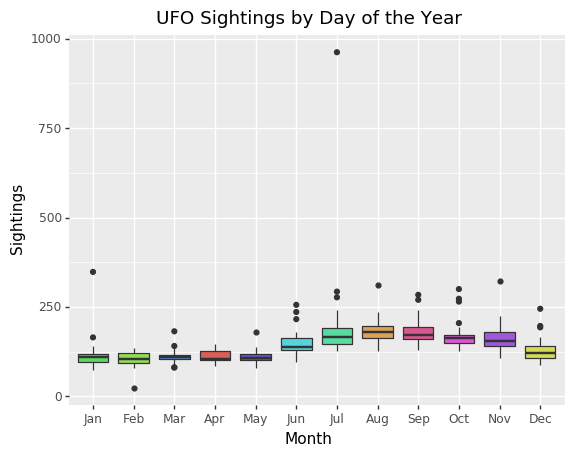

<ggplot: (-9223372029847253623)>

In [16]:
# Created alternative version in R with labels. Highest value is July 4th, second is Jan 1st.
(ggplot(day_counts, aes(x = "month_name",y = 'count',fill = 'month_name'))+geom_boxplot()+scale_x_discrete(name ="Month", limits=["Jan","Feb","Mar",'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])+
labs(title = "UFO Sightings by Day of the Year", y = "Sightings", x = 'Month'))+ guides(fill=False)
 
 

After analyzing the times of day when most sightings occurred, we became interested in what specific days UFO sightings were most likely to occur. The box plot below, ‘UFO Sightings by Day of the Year’, collates information from 1999-2013 and displays the general range for sightings per month, along with the outliers for the month. An interesting finding from the box plot is that there are specific days in January and July that have a much larger amount of reported sightings. Upon further investigation, the two days that stuck out as the largest outliers were July 4th and January 1st. Over the 14 year period, there were 962 reported UFO sightings on the 4th of July and 348 reported sightings on New Year’s day. The box plot also shows that in the latter half of the year there are more reported sightings than in the beginning of the year. 


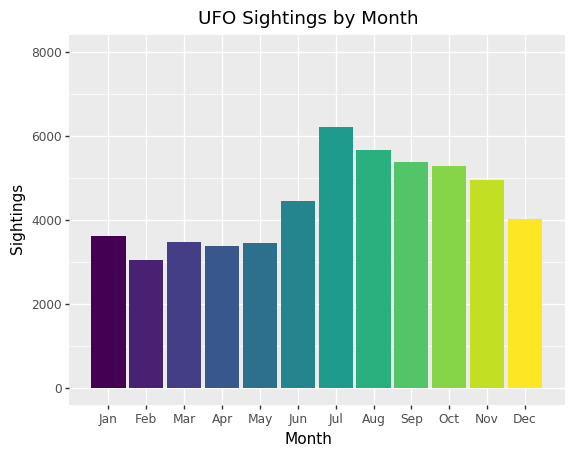

<ggplot: (-9223372036578330652)>

In [17]:
# Months
month_counts = day_time['month'].value_counts()
month_counts = pd.DataFrame(month_counts).reset_index()
month_counts.columns.values[[0,1]] = ["month","count"]
month_counts

(ggplot(month_counts, aes(x = "month",y = 'count', fill = 'month'))+geom_bar(stat = 'identity',position = position_dodge)+scale_x_discrete(name ="Month", limits=["Jan","Feb","Mar",'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])+
labs(title = "UFO Sightings by Month", y = "Sightings", x = 'Month'))+ guides(fill=False)+ylim(0,8000)
#+ theme(legend.position = "none")#+theme(axis_text_x = element_text(angle = 30,hjust = 1,size = 8))




In [18]:
# By Year

# Frequency data for UFO's per year
ufo['year'] = ufo['datetime'].dt.strftime('%Y')
ufo_year_counts = ufo['year'].value_counts()
ufo_year_counts = pd.DataFrame(ufo_year_counts).reset_index()
ufo_year_counts.columns.values[[0,1]] = ["year","ufo_count"]
ufo_year_counts['year'] = ufo_year_counts.year.astype(int)



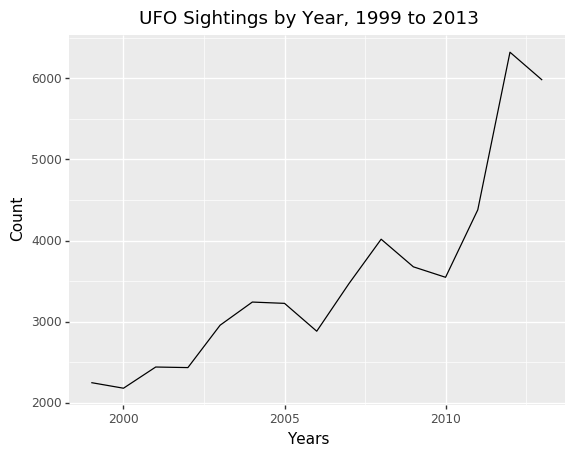

<ggplot: (-9223372036578266985)>

In [19]:
(ggplot(ufo_year_counts, aes(y = 'ufo_count', x = 'year'))+geom_line()+labs(title = "UFO Sightings by Year, 1999 to 2013", y = "Count", x = 'Years'))#+ scale_x_discrete(name ="Year", limits=["1999","2000","2001",'2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013']))
# This should be next to the Sci-Fi movie releases by year. See movie analysis section.
 

# Frequency Analyses

Our UFO data contains two categories that describe each individual sighting: *shape* and *comments*. We can use these categories (columns) to conduct word frequency analyses and find what words/shapes people use to describe their reported sightings.

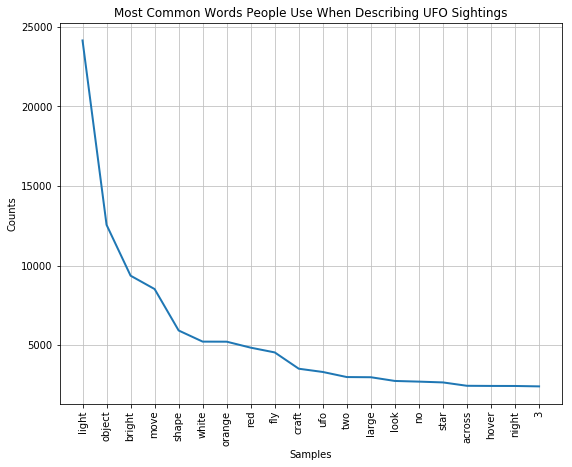

Text(17.200000000000003, 0.5, '_____')

In [18]:
text_ufo = ufo.loc[:,'comments']
# text_ufo = re.sub('\\#44','',text_ufo.astype(str))
text_ufo = text_ufo.str.cat(sep=', ')

ufo_words = nltk.word_tokenize(text_ufo.lower())

ufo_tags = nltk.pos_tag(ufo_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in ufo_tags]


stopwords = nltk.corpus.stopwords.words("english")
stopwords = [stopwords,'44','39','i','a','and','of','to','at','the','then','in','be','it','over','on','fly,','my','with','from','see','saw','very','that','like','for','sky']
words_cont = [w for w in words if w not in stopwords]
fq = nltk.FreqDist(w for w in words_cont if w.isalnum())


#fq.most_common(25)

#ufo_fq = fq.plot(20, cumulative = False)

ufo_fq = plt.figure(figsize = (9,7))
fq.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO Sightings")
ax = ufo_fq.get_axes()[0]
ax.set_xlabel("Words")
ax.set_ylabel("_____")


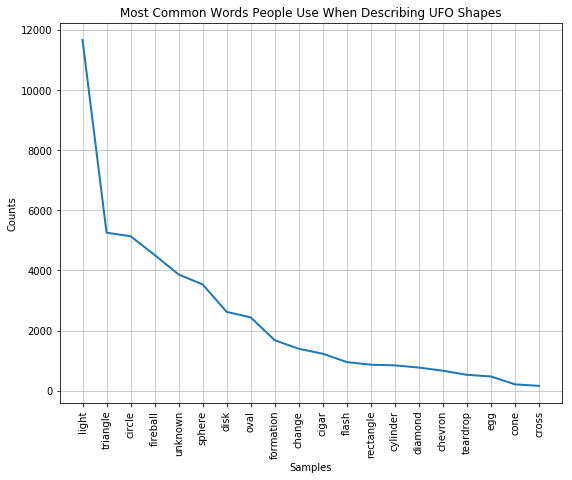

In [19]:
text_shape = ufo.loc[:,'shape']
text_shape = text_shape.str.cat(sep=', ')

shape_words = nltk.word_tokenize(text_shape.lower())
shape_words

shape_tags = nltk.pos_tag(shape_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in shape_tags]


stopwords = nltk.corpus.stopwords.words("english")
words_cont = [w for w in words if w not in stopwords]
fq2 = nltk.FreqDist(w for w in words_cont if w.isalnum())

shape_fq = plt.figure(figsize = (9,7))
fq2.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO Shapes")

#shape_fq = fq2.plot(20, cumulative = False)

In [20]:
# Creating subsets by specific days, namely holidays 
# New Years is the second most common day for sightings

newyears_ufo = ufo.set_index(pd.DatetimeIndex(ufo['datetime']))


list_months = [1]
list_days = ['01']
newyears_ufo = newyears_ufo[newyears_ufo.index.to_series().dt.month.isin(list_months)]
newyears_ufo = newyears_ufo[newyears_ufo.index.to_series().dt.day.isin(list_days)]


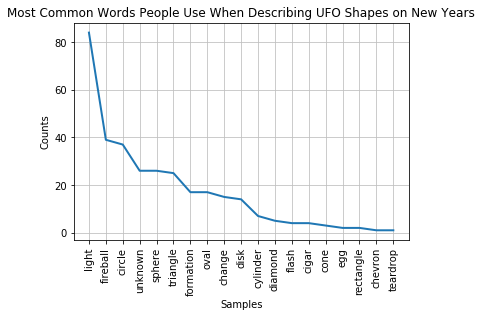

In [21]:
# New Years

text_shape = newyears_ufo.loc[:,'shape']
text_shape = text_shape.str.cat(sep=', ')

shape_words = nltk.word_tokenize(text_shape.lower())
shape_words

shape_tags = nltk.pos_tag(shape_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in shape_tags]


stopwords = nltk.corpus.stopwords.words("english")

words_cont = [w for w in words if w not in stopwords]
fq = nltk.FreqDist(w for w in words_cont if w.isalnum())
fq.most_common(25)
#shape_fq = plt.figure(figsize = (9,7))
fq.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO Shapes on New Years")


Interestingly, we see that fireball is the second most common for both July 4th and New Years. In the overall dataset, we see that fireball is 4th, while triangle and circle and 2nd and 3rd.


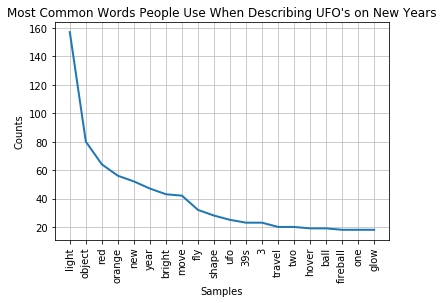

In [22]:
# New Years

text_shape = newyears_ufo.loc[:,'comments']
text_shape = text_shape.str.cat(sep=', ')

shape_words = nltk.word_tokenize(text_shape.lower())
shape_words

shape_tags = nltk.pos_tag(shape_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in shape_tags]


stopwords = nltk.corpus.stopwords.words("english")
stopwords = [stopwords,'44','39','i','a','and','of','to','at','the','then','in','be','it','over','on','fly,','my','with','from','see','saw','very','that','like','for','sky']
words_cont = [w for w in words if w not in stopwords]
fq = nltk.FreqDist(w for w in words_cont if w.isalnum())
fq.most_common(25)

fq.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO's on New Years")


In [23]:
# July 4th is the most common day for UFO sightings

july4_ufo = ufo.set_index(pd.DatetimeIndex(ufo['datetime']))


list_months = [7]
list_days = ['04']
july4_ufo = july4_ufo[july4_ufo.index.to_series().dt.month.isin(list_months)]
july4_ufo = july4_ufo[july4_ufo.index.to_series().dt.day.isin(list_days)]




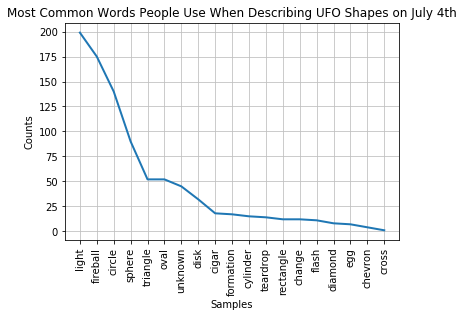

In [24]:
# July 4th


text_shape = july4_ufo.loc[:,'shape']
text_shape = text_shape.str.cat(sep=', ')

shape_words = nltk.word_tokenize(text_shape.lower())
shape_words

shape_tags = nltk.pos_tag(shape_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in shape_tags]


stopwords = nltk.corpus.stopwords.words("english")
words_cont = [w for w in words if w not in stopwords]
fq = nltk.FreqDist(w for w in words_cont if w.isalnum())
fq.most_common(25)

fq.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO Shapes on July 4th")


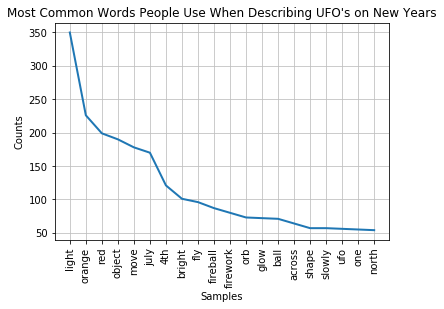

In [25]:
# July 4th


text_shape = july4_ufo.loc[:,'comments']
text_shape = text_shape.str.cat(sep=', ')

shape_words = nltk.word_tokenize(text_shape.lower())
shape_words

shape_tags = nltk.pos_tag(shape_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in shape_tags]


stopwords = nltk.corpus.stopwords.words("english")
stopwords = [stopwords,'44','39','i','a','and','of','to','at','the','then','in','be','it','over','on','fly,','my','with','from','see','saw','very','that','like','for','sky']
words_cont = [w for w in words if w not in stopwords]
fq = nltk.FreqDist(w for w in words_cont if w.isalnum())
fq.most_common(25)

fq.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO's on New Years")


In [26]:
# Halloween is the fifth most common day
hallo_ufo = ufo.set_index(pd.DatetimeIndex(ufo['datetime']))


list_months = [10]
list_days = ['31']
hallo_ufo = hallo_ufo[hallo_ufo.index.to_series().dt.month.isin(list_months)]
hallo_ufo = hallo_ufo[hallo_ufo.index.to_series().dt.day.isin(list_days)]


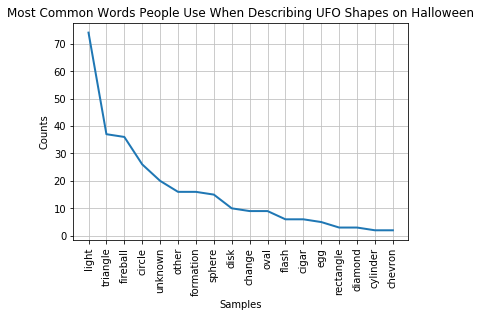

In [27]:
# Halloween

text_shape = hallo_ufo.loc[:,'shape']
text_shape = text_shape.str.cat(sep=', ')

shape_words = nltk.word_tokenize(text_shape.lower())
shape_words

shape_tags = nltk.pos_tag(shape_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in shape_tags]


stopwords = nltk.corpus.stopwords.words("english")
stopwords = [stopwords,'44','39','i','a','and','of','to','at','the','then','in','be','it','over','on','fly,','my','with','from','see','saw','very','that','like','for','sky']
words_cont = [w for w in words if w not in stopwords]
fq = nltk.FreqDist(w for w in words_cont if w.isalnum())

fq.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO Shapes on Halloween")


We used the comments category from the UFO data set to perform a word frequency analysis on the most common words people use to describe their UFO sighting. The words found in the chart below, specifically “light,” “bright,” “white,” “orange,” and “red,” show that some of the most popular words people use to describe their reported UFO sighting revolve around light and color. We also see large counts of the words “object” and “craft,” possibly indicating they saw not just a bright light but an actual object in the sky. 

The UFO data also included a shape category, which is the shape used to describe the reported UFO sightings. To determine what the most popular shapes are for reported UFO sightings we looked at three different holidays: New Year’s Day, the 4th of July, and Halloween (New Year’s Day and the 4th of July are also the two days with the highest amount of reported UFO sightings; Halloween is the fifth) and performed individual word frequency analyses. Both New Year’s Day and the 4th of July showed a similar display of words used to describe the shape seen, in fact, the top 20 words are in almost the exact same order for both graphs. The top 20 most common words on Halloween are nearly identical to the words used on New Year’s Day and the 4th of July. However, on Halloween the word ‘triangle’ is the 2nd most common word, compared to the two other days where ‘triangle’ is only the 6th most common word. Interestingly, the word ‘light’ is used to describe the shape of the UFOs. This is interesting because light is not a shape, but we acknowledge that ‘lights in the sky’ and similar variations are a common way to describe UFO sightings. The use of the word ‘fireball’ is also interesting because both the 4th of July and New Year’s Day are common days that fireworks appear in the sky, and the word ‘fireball’ is an accurate description of the shape of a firework. However, ‘fireball’ is the 3rd most common word used on Halloween, and fireworks don’t typically appear in the sky on Halloween. This analysis of the shapes used to describe UFO sightings on New Year’s Day, the 4th of July, and Halloween appears to show that there is little change in how people describe their UFO sightings based off of the day.


# Analysis by State

After analyzing our data by day and month of the year, we wanted to continue our analysis by determining relationships between UFO sightings and state metrics. 

In [162]:
# DataFrames for UFO Frequencies per State

# Frequency data per state
value_counts = ufo['state'].value_counts()
value_counts = pd.DataFrame(value_counts).reset_index()
value_counts.columns.values[[0,1]] = ["state","ufo_counts"]
top10_states = value_counts[0:10]


# Adding population data
tabs = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population')
tbl = tabs[0]

# Combine table headers into one row.
cols = list(tbl.columns.get_level_values(0))

cols = tbl.columns[0:]
col_list = [2,4]

df = tbl[col_list]

new_header = df.iloc[0] # grab the first row for the header
df = df[1:] # take the data less the header row
df.columns = new_header # set the header row as the df header

df.columns.values[[0,1]] = ['full_state','2010_pop']

df = df[0:52]
df = df.reset_index()
df = df.drop('index',1)
df = df.drop(df.index[[29]])


state_dict = {"Alabama" : "AL", "Alaska" : "AK", "Arizona" : "AZ", "Arkansas" : "AR", 'California' : 'CA', 
              'Colorado' : 'CO', 'Connecticut' : 'CT', 'Delaware' : 'DE','District of Columbia' : 'DC', 'Florida' : 'FL', 'Georgia' : 'GA',
              'Hawaii' : 'HI', 'Idaho' : 'ID', 'Illinois' : 'IL', 'Indiana' : 'IN', 'Iowa' : 'IA', 'Kansas' : 'KS',
              'Kentucky' : 'KY', 'Louisiana' : 'LA', 'Maine' : 'ME', 'Maryland' : 'MD', 'Massachusetts' : 'MA', 
              'Michigan' : 'MI', 'Minnesota' : 'MN', 'Mississippi' : 'MS', 'Missouri' : 'MO', 'Montana' : 'MT', 
              'Nebraska' : 'NE', 'Nevada' : 'NV', 'New Hampshire' : 'NH' , 'New Jersey': 'NJ', 'New Mexico' : 'NM',
              'New York' : 'NY', 'North Carolina' : 'NC', 'North Dakota' : 'ND', 'Ohio' : 'OH', 'Oklahoma' : 'OK', 
              'Oregon' : 'OR', 'Pennsylvania' : 'PA' , 'Rhode Island' : 'RI', 'South Carolina' : 'SC', 
              'South Dakota' : 'SD', 'Tennessee' : 'TN', 'Texas' : 'TX', 'Utah' : 'UT', 'Vermont' : 'VT',
              'Virginia' : 'VA', 'Washington' : 'WA', 'West Virginia' : 'WV', 'Wisconsin' : 'WI', 'Wyoming' : 'WY', 'DC': 'Washington, D.C.'}

df['state'] = df['full_state'].map(state_dict)
        
states = pd.merge(df,value_counts, on = 'state')
states['2010_pop'] = pd.to_numeric(df['2010_pop'])


In [ ]:
# New column as float instead of string
ufo['year_float'] = ufo['year'].astype(float)

In [273]:
# Let's get observations by state per year
def df_subset(df,year):
'''Function that creates subset of ufo data frame based on year'''
    new_df = df[df['year_float'] == year]
    return new_df
    

In [297]:
def frequency_counts(year):
'''Function takes year input, creates subset based on year input, and returns
frequency count for each state.'''
    year_df = df_subset(ufo,year)
    value_count = year_df['state'].value_counts()
    value_count = pd.DataFrame(value_count).reset_index()
    value_count.columns.values[[0,1]] = ["state",year]
    return value_count
    
    

In [318]:
# Loops creation of frequency counts for each year in data frame
all_years = pd.DataFrame(states['state'])
for i in range(1999,2014):
    all_years = all_years.merge(frequency_counts(i))
all_years.head()

,state,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,AL,24,18,10,15,35,25,34,33,42,42,30,23,33,51,67
1,AK,13,11,14,7,11,9,15,13,4,9,14,10,16,42,41
2,AZ,79,173,94,98,103,163,163,112,110,148,140,97,138,177,193
3,AR,29,31,25,26,44,29,30,24,25,31,25,34,38,51,47
4,CA,321,380,317,367,517,481,470,469,519,619,562,516,541,639,607


In [20]:
# Creating a California and CA 2013 subset for later usage.
california = ufo[ufo['state'] == 'CA']
california_2013 = california[california['datetime'] > '2012-12-31']


In [163]:
# Utah has a missing value -> replaces the NaN
states['2010_pop'][29] = 2776000

/Users/Tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [164]:
# Finding percentages per state and by population
states['percentage'] = states['ufo_counts']/53012
states['state_percentage'] = states['ufo_counts']/states['2010_pop']
states['per_10000'] = states['state_percentage'].apply(lambda x: x*10000)


In [165]:
# Adding unemployment data
unemploy = pd.ExcelFile('~/Desktop/ufo-sightings/emp-unemployment.xls')
unemploy = pd.read_excel(unemploy,1)
unemploy = unemploy.drop(unemploy.columns[2:32], axis = 1)
unemploy = unemploy.drop(unemploy.columns[0], axis = 1)
unemploy = unemploy.drop(unemploy.columns[2:], axis = 1)

unemploy.columns.values[[0,1]] = ['state','unemployment_rate_2010']
unemploy = unemploy.drop(unemploy.index[0:6])
unemploy = unemploy.reset_index()
unemploy = unemploy.drop('index',1)
unemploy = unemploy.drop(unemploy.index[51:])

for key in state_dict.keys():
        unemploy['state'] = unemploy['state'].replace(key, state_dict[key])

        
states = pd.merge(unemploy,states, on = 'state')

In [166]:
# Adding binge drinking prevalence, unfortunately we could only find 2015 data.
tabs = pd.read_html('https://www.cdc.gov/alcohol/data-table-text.htm#intensity')
tbl = tabs[0]

binge = tbl.drop(tbl.index[0:3])
binge = binge.reset_index()
binge = binge.drop('index',1)
binge = binge.drop(binge.index[[17,18,36,37]])
binge.columns.values[[0,1]] = ['state','binge_drinking']

for key in state_dict.keys():
        binge['state'] = binge['state'].replace(key, state_dict[key])

        
states = pd.merge(binge,states, on = 'state')
states['binge_drinking'] = states['binge_drinking'].astype(float)

In [167]:
# Adding opiod prescriptions, 2010
tabs = pd.read_html('https://www.cdc.gov/drugoverdose/maps/rxstate2010.html')
opiods = tabs[0]
opiods = opiods.drop(opiods.columns[[0]], axis = 1)
opiods.columns.values[[0,1]] = ['state','opiod_prescrip/100per']
       
states = pd.merge(opiods,states, on = 'state')
states['opiod_prescip/100per'] = states['opiod_prescrip/100per'].astype(float)

# Fixing/Reordering data frame
states = states.drop(states.columns[[-1]],axis = 1)

In [168]:
# Adding voting data by state, 2010

tabs = pd.read_html('https://en.wikipedia.org/wiki/Red_states_and_blue_states')
voter = tabs[11] # eleventh table on the page
voter = voter.drop(voter.columns[1:10], axis = 1)
voter = voter.drop(voter.columns[3], axis = 1)
voter = voter.drop(voter.index[[0,1,2,3,12,24,25,34]])
voter = voter.reset_index()
voter = voter.drop('index',1)
voter.columns.values[[0,1,2]] = ['state','2008_vote','2012_vote']
states['2010_pop'][29] = 2776000
voter['2008_vote'][26] = 'McCain'
for key in state_dict.keys():
        voter['state'] = voter['state'].replace(key, state_dict[key])
states = pd.merge(voter,states, on = 'state')

/Users/Tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [169]:
# Adding urban population percentage, 2010
tabs = pd.read_html('https://en.wikipedia.org/wiki/Urbanization_in_the_United_States')
rural = tabs[0]
rural = rural.drop(rural.columns[2:], axis = 1)
#rural['0'] = rural['0'].astype(str)
rural = rural.drop(rural.index[0:6])
new_header = rural.iloc[0] # grab the first row for the header
rural = rural[1:] # take the data less the header row
rural.columns = new_header # set the header row as the df header
rural.columns.values[[0,1]] = ['state','urban_pop_2010']
rural = rural.drop(rural.index[-1])
rural = rural.reset_index()
rural = rural.drop('index',1)
#df['DATE'] = df['DATE'].astype(str).str[:-2].astype(np.int64)
rural['state'] = rural['state'].str[:-3]
rural['state'] = rural['state'].str.replace('[','')
rural['urban_pop_2010'] = rural['urban_pop_2010'].str.replace('%','')
rural.urban_pop_2010 = rural.urban_pop_2010.astype(float)

for key in state_dict.keys():
        rural['state'] = rural['state'].replace(key, state_dict[key])
states = pd.merge(rural,states, on = 'state')

In [170]:
states = states[['state','full_state','2008_vote','2012_vote','ufo_counts','2010_pop','urban_pop_2010','per_10000','unemployment_rate_2010','binge_drinking','opiod_prescrip/100per']]
states.head()

,state,full_state,2008_vote,2012_vote,ufo_counts,2010_pop,urban_pop_2010,per_10000,unemployment_rate_2010,binge_drinking,opiod_prescrip/100per
0,AL,Alabama,McCain,Romney,482,4780127.0,59.0,1.008341,10.5,12.2,134.3
1,AK,Alaska,McCain,Romney,229,672591.0,66.0,3.404744,7.9,20.0,68.4
2,AZ,Arizona,McCain,Romney,1988,6392307.0,89.8,3.109988,10.4,15.0,88.5
3,AR,Arkansas,McCain,Romney,489,2700691.0,56.2,1.810648,8.2,15.2,120.8
4,CA,California,Obama,Obama,7325,37252895.0,95.2,1.966290,12.2,16.7,55.8


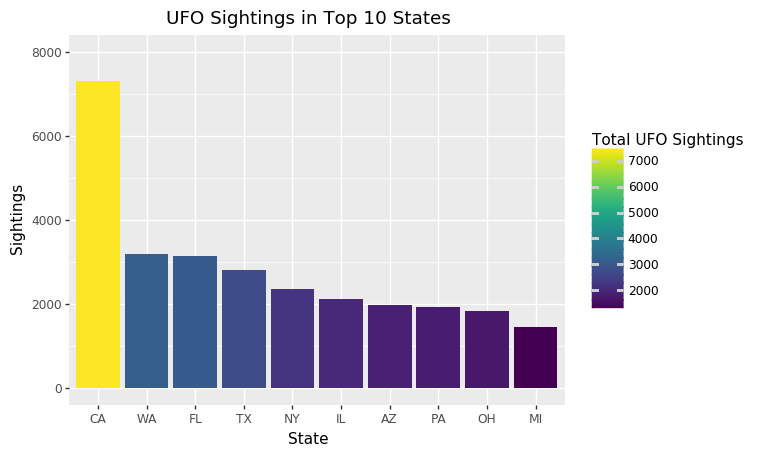

<ggplot: (7547322958)>

In [47]:
# State UFO Plots
# For top 10 sighting states
(ggplot(top10_states, aes(x = "state",y = 'ufo_counts', fill = 'ufo_counts'))+geom_bar(stat = 'identity',position = position_dodge(width = 0.9))+ylim(0,8000)+scale_x_discrete(name ="State", limits=["CA","WA","FL",'TX','NY','IL','AZ','PA','OH','MI'])+
labs(title = "UFO Sightings in Top 10 States", y = "Sightings", x = 'State',fill = "Total UFO Sightings"))#+labs(fill='Total UFO Sightings'))



We wanted to know which states had the most reported UFO sightings over our 14 year time period. We created the above bar chart which reveals the top 10 states for reported UFO sightings. We immediately noticed that California has significantly more reported UFO sightings than any other state. It has approximately two times more reported sightings than the next highest state, Washington. The next three states include Florida, Texas, and Washington. Four out of the top five states in terms of reported UFO sightings are also the largest four states in the United States by population. This bar chart confirms to us that a state’s population is a significant factor in reported UFO sightings per state. In our later analysis, we directly address this issue by calculating the number of sightings per 10,000 people in each state.

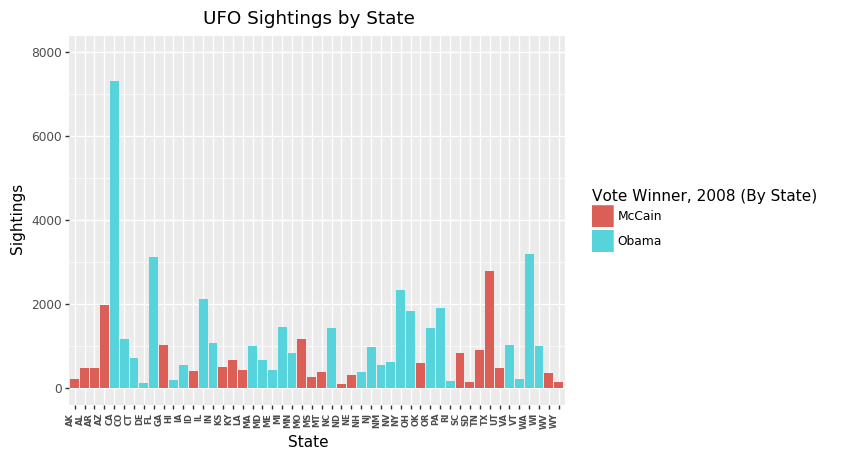

<ggplot: (7558494030)>

In [141]:
# State UFO Plots - Voting Data not adjusted by population
(ggplot(states, aes(x = "state",y = 'ufo_counts', fill = '2008_vote'))+geom_bar(stat = 'identity',position = position_dodge(width = 0.9))+ylim(0,8000)+
labs(title = "UFO Sightings by State", y = "Sightings", x = 'State',fill = "Vote Winner, 2008 (By State)"))+theme(axis_text_x = element_text(angle = 90, size = 6,hjust=1,face = 'bold'))



In the above plot of voter data by state, we observe that all states with UFO sighting counts over 2000 are 'blue' states. Additionally, we notice that on average, 'red' states have fewer sightings overall than blue states. However, this may be related to the fact that Republican states usually are more rural and lack a substantial population. To address this fact, we must observe the per-capita UFO sightings (sightings per 10,000 population). Below we created a graph that accounts for state population. We see that of the states with sightings greater than 3 per 10,000 population, 4 of the 6 are 'blue' states. 

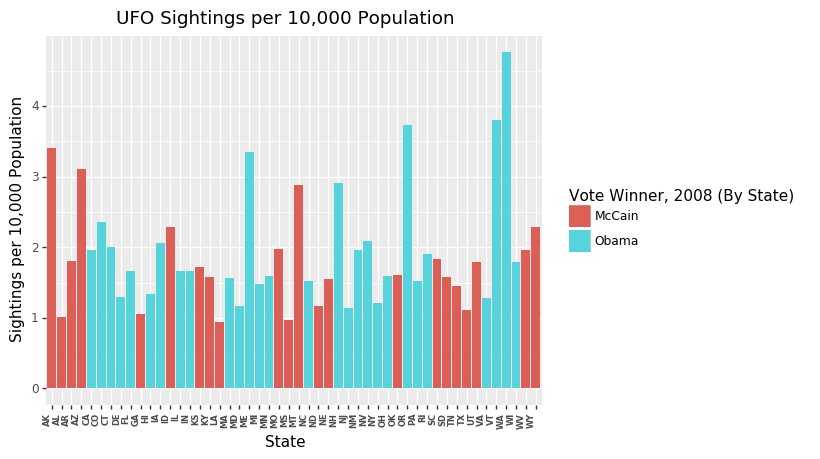

<ggplot: (-9223372029305323541)>

In [144]:
# State UFO Plots - Voting Data: Per Capita
(ggplot(states, aes(x = "state",y = 'per_10000', fill = '2008_vote'))+geom_bar(stat = 'identity',position = position_dodge(width = 0.9))+
labs(title = "UFO Sightings per 10,000 Population", y = "Sightings per 10,000 Population", x = 'State',fill = "Vote Winner, 2008 (By State)"))+theme(axis_text_x = element_text(angle = 90, size = 6,hjust=1,face = 'bold'))



In [174]:
# Let's find out what per-capita sightings are for Red and Blue states
red_states = states[states['2008_vote'] == 'McCain']
blue_states = states[states['2008_vote'] == 'Obama']
print(np.mean(red_states['per_10000']))
np.mean(blue_states['per_10000'])
# So we can see that 'blue' states have on average, 0.24 more UFO sightings than 'red' states.

1.776200654974817


2.012405753960698

# Interactive Plots

In [125]:
# More info about relationships between drinking and UFO sightings
states['adj_sobriety'] = states['per_10000']*(1-(states['binge_drinking']/100))
#states[states['binge_drinking'] >= 20]
#states[states['unemployment_rate_2010'] >= 10]

In [126]:
print(high5(states,'binge_drinking'))

states[states['per_10000'] >= 3]

   state    full_state 2008_vote 2012_vote  ufo_counts    2010_pop  \
33    ND  North Dakota    McCain    Romney          95    814191.0   
48    WI     Wisconsin     Obama     Obama        1019   5687289.0   
25    MT       Montana    McCain    Romney         382   1328361.0   
14    IA          Iowa     Obama     Obama         568   2763888.0   
12    IL      Illinois     Obama     Obama        2128  12831549.0   

    urban_pop_2010  per_10000  unemployment_rate_2010  binge_drinking  \
33            59.9   1.166802                     3.8            24.9   
48            70.2   1.791715                     8.7            24.4   
25            55.9   2.875724                     7.3            21.3   
14            64.0   2.055076                     6.0            21.3   
12            88.5   1.658412                    10.4            20.8   

    opiod_prescrip/100per  adj_sobriety  
33                   63.0      0.876269  
48                   74.4      1.354536  
25            

,state,full_state,2008_vote,2012_vote,ufo_counts,2010_pop,urban_pop_2010,per_10000,unemployment_rate_2010,binge_drinking,opiod_prescrip/100per,adj_sobriety
1,AK,Alaska,McCain,Romney,229,672591.0,66.0,3.404744,7.9,20.0,68.4,2.723795
2,AZ,Arizona,McCain,Romney,1988,6392307.0,89.8,3.109988,10.4,15.0,88.5,2.643490
18,ME,Maine,Obama,Obama,441,1316466.0,38.7,3.349878,8.1,20.2,92.8,2.673202
36,OR,Oregon,Obama,Obama,1428,3831073.0,81.0,3.727415,10.6,17.7,101.2,3.067663
44,VT,Vermont,Obama,Obama,229,601767.0,38.9,3.805460,6.1,19.0,54.1,3.082422
46,WA,Washington,Obama,Obama,3201,6724543.0,84.0,4.760175,10.0,16.6,85.0,3.969986


In [127]:
states_alt = states.copy()
for col in states_alt.columns:
    states_alt[col] = states_alt[col].astype(str)
scl = [
    [0.0, 'rgb(242,240,247)'],
    [0.2, 'rgb(218,218,235)'],
    [0.4, 'rgb(188,189,220)'],
    [0.6, 'rgb(158,154,200)'],
    [0.8, 'rgb(117,107,177)'],
    [1.0, 'rgb(84,39,143)']
]





states_alt['text'] = states_alt['full_state'] + '<br>' +'Total UFO Sightings: ' + states_alt['ufo_counts'] + '<br>' + 'Urban Population % (2010): '+ states_alt['urban_pop_2010']+'<br>'+ 'Binge Drinking Prevalence: ' + states_alt['binge_drinking']+'%'+ '<br>'+ 'Opioid Prescriptions/100 Persons (2010): '+ states_alt['opiod_prescrip/100per']+'<br>'+'Unemployment Rate (2010): ' + states_alt['unemployment_rate_2010']+'%'


data = [go.Choropleth(
    colorscale = scl,
    autocolorscale = False,
    locations = states_alt['state'],
    z = states_alt['per_10000'].astype(float),
    locationmode = 'USA-states',
    text = states_alt['text'],
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(255,255,255)',
            width = 2
        )),
    colorbar = go.choropleth.ColorBar(
        title = "UFO Sightings by State (per 10,000 Population)")
)]

layout = go.Layout(
    title = go.layout.Title(
        text = 'Binge Drinking, Opioid Prescriptions, Unemployment Rates, Urban Population<br>And UFO Sightings,<br>1999 to 2013<br>(Hover for breakdown)'
    ),
    geo = go.layout.Geo(
        scope = 'usa',
        projection = go.layout.geo.Projection(type = 'albers usa'),
        showlakes = True,
        lakecolor = 'rgb(85, 173, 240)'),
)

fig = go.Figure(data = data, layout = layout)
#py.iplot(fig, filename = 'd3-cloropleth-map')
iplot(fig)

We were interested in what other factors within a state affect UFO sightings, other than population. To determine this, we collected data on binge drinking prevalence, opioid prescriptions, urban population percentage, and unemployment rates in 2010. We found that for every state with over 3 sightings per 10,000 people, the binge drinking prevalence (%) was at least 15%. In 2010, the nationwide unemployment rate was 9.6%; for three of the six states with UFO sightings of more than 3 per 10,000, their unemployment rate was over the national average. While not a definitive statement of causation, it is an interesting metric we noticed in our data. We also found that urban population percentage was not indicative of total UFO sightings. Out of the six states with more than three sightings per 10,000 people, four had more than 50% of the population living in urban areas. We were unable to determine any relationship between opioid prescription rates and UFO sightings, but we found it to be an interesting enough statistic to leave in our plot.

In [1074]:
# Saving clean csv's for R usage
# Do regression on states data
# US_csv = ufo.to_csv(r'~/Desktop/US_UFO.csv', index = None, header=True)
# ca_csv = california.to_csv(r'~/Desktop/CA_UFO.csv', index = None, header=True) 
# state_csv = states.to_csv(r'~/Desktop/states.csv',index = None, header = True)             
# day_counts_csv = day_counts.to_csv(r'~/Desktop/day_counts.csv',index = None, header = True)
# movies_and_ufo_csv = movies_and_ufo.to_csv(r'~/Desktop/movies_and_ufo.csv',index = None, header = True)


# Choropleth and Cluster Maps

In [37]:
locations = california_2013[['latitude', 'longitude ']]
locationlist = locations.values.tolist()
labels = california_2013['shape'].values.astype(str).tolist()
labels_duration = california_2013['duration (hours/min)'].values.astype(str).tolist()


In [126]:
# Cluster Map of California 2013 Sightings
# https://georgetsilva.github.io/posts/mapping-points-with-folium/
map2 = folium.Map(location = [38.437574,-121.849776], zoom_start = 9)
marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup = folium.Popup('Shape: '+labels[point]+', Duration: '+labels_duration[point]),icon=folium.Icon(color='black', icon_color='green', icon='male', angle=0, prefix='fa')).add_to(marker_cluster)
map2

#for point in range(0, len(locationlist)):
 #   folium.Marker(locationlist[point], popup='ID:'+df_counters['ID'][point]+' '+df_counters['Name'][point], icon=folium.Icon(color=df_counters["color"][point], icon_color='white', icon='male', angle=0, prefix='fa')).add_to(marker_cluster)



In [39]:
locations2 = july4_ufo[['latitude', 'longitude ']]
locationlist2 = locations2.values.tolist()
labels2 = july4_ufo['shape'].values.astype(str).tolist()
labels_duration2 = july4_ufo['duration (hours/min)'].values.astype(str).tolist()


In [127]:
# Cluster Map of July 4th Sightings
map3 = folium.Map(location = [22.9,-128.1], zoom_start = 9)
marker_cluster = MarkerCluster().add_to(map3)

for point in range(0, len(locationlist2)):
    folium.Marker(locationlist2[point], popup = folium.Popup('Shape: '+labels2[point]+', Duration: '+labels_duration2[point]),icon=folium.Icon(color='black', icon_color='green', icon='male', angle=0, prefix='fa')).add_to(marker_cluster)
map3




In [ ]:
# Need to create all_years interactive plot for the changing sightings in state over the years


In [ ]:
# Choropleth for % of sightings by state population
state_geo = os.path.join('/Users/Tim/Desktop/us-states.json')

m = folium.Map(location=[37, -102], zoom_start=5)


m.choropleth(
 geo_data=state_geo,
 name='Choropleth',
 data=states,
 columns=['state', 'state_percentage'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='UFO Sightings in the United States by State Population (%), 1999 to 2013'
)
folium.LayerControl().add_to(m)

m.save('UFO%MapbyState.html')




In [84]:
# Choropleth for % of sightings by state population
state_geo = os.path.join('/Users/Tim/Desktop/ufo-sightings/us-states.json')

m = folium.Map(location=[37, -102], zoom_start=5)


m.choropleth(
 geo_data=state_geo,
 name='Choropleth',
 data=states,
 columns=['state', 'per_10000'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='UFO Sightings in the United States by State per 10,000 People, 1999 to 2013'
)
folium.LayerControl().add_to(m)

m.save('UFOper10000.html')




Adjusted for population, we immediately notice that the Midwest and the South have low instances of UFO sightings per 10,000 people. On the other hand, we can see that Washinton, Alaska, Arizona,Oregon, Vermont, and Maine have higher instances of UFO sightings per 10,000 people (> 3/10000). Additionally, even with Area 51's reputation and the conspiracy theories that surround the base, there is a fairly low rate of sightings among people in Nevada.

In [ ]:
# Chloropath map for data: Binge Drinking Prevalence
# https://www.cdc.gov/alcohol/data-table-text.htm#intensity
binge = folium.Map(location=[37, -102], zoom_start=5)


binge.choropleth(
 geo_data=state_geo,
 name='Choropleth',
 data=states,
 columns=['state', 'binge_drinking'],
 key_on='feature.id',
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Binge Drinking Prevalence (% by State), 2015'
)
folium.LayerControl().add_to(binge)

binge.save('UFOBinge.html')



# Movies

As mentioned in our introduction, we were interested in the how science fiction movies can provoke our imagination and potentially influence sightings of UFO's. We obtained our data through scraping the IMDB movie release database and controlling for genre. You can find the code for our work in the 'movieCleaning.ipynb' file in our repository.

In order to determine whether a sighting was influenced by a UFO sighting, we decided to deem the two days after release as the most popular and influential days: the opening weekend as it were. After reading in our data, we merged the UFO and movie data sets by comparing the datetime found in the UFO data with the range of dates in our movie data.

In [51]:
movie_df = pd.read_csv('~/Desktop/ufo-sightings/movie.csv',lineterminator='\n') # Fixes upload issue

# Needed to change to datetime format
movie_df["release_date"] = movie_df["release_date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

movie_df["end_range"] = movie_df["end_range"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

movie_df["opening_weekend"] = movie_df["opening_weekend"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

movie_df['year_release'] = movie_df['release_date'].dt.strftime('%Y')

movie_df.dtypes


title                      object
release_date       datetime64[ns]
overview                   object
end_range          datetime64[ns]
opening_weekend    datetime64[ns]
year_release               object
dtype: object

We chose the two days immediately after a movie's release as the most popular time for a movie. Often the popularity of new movies is predicted based on the money made on the first weekend of it's release. While we cannot determine exactly what day a movie is realeased (for example, a movie could be released on a Tuesday, so the next two days per our function would be weekdays, but called 'opening weekend'), we are assuming that the first several days of release are some of the most popular for a movie and when the events of a movie would weigh heavily on audience members' minds. This could then influence the possibilty of a UFO sighting, which is exactly what we are attempting to determine.

In [52]:
# https://stackoverflow.com/questions/43593554/merging-two-dataframes-based-on-a-date-between-two-other-dates-without-a-common
movie_test = movie_df.copy()
ufo_test = california.copy()

In [53]:
ufo_test = ufo_test.assign(key = 1)
movie_test = movie_test.assign(key = 1)
movie_ufo = pd.merge(ufo_test, movie_test, on = 'key').drop('key', axis = 1)

In [54]:
#movie_ufo = movie_ufo.query('newtime >= release_date and newtime <= end_range')

# Searches for UFO sightings where a movie was released within two days.
movie_ufo = movie_ufo.query('newtime >= release_date and newtime <= opening_weekend')




In [55]:
#out_df = movie_test.merge(movie_ufo, on = ['release_date','end_range'], how = 'left').fillna('').drop('key',axis = 1)
out_df = ufo_test.merge(movie_ufo, on = ['datetime'], how = 'left').fillna('').drop('key',axis = 1)



In [49]:
len(out_df) # 14328

14328

In [61]:
# https://stackoverflow.com/questions/51182228/python-delete-duplicates-in-a-dataframe-based-on-two-columns-combinations
out_df3 = out_df[~out_df[['city_x', 'shape_x','comments_x']].apply(frozenset, axis=1).duplicated()]
print(len(out_df3))

out_df3.head()

7320


,datetime,city_x,state_x,country_x,shape_x,duration (seconds)_x,duration (hours/min)_x,comments_x,date posted_x,latitude_x,...,latitude_y,longitude _y,newtime_y,year_y,title,release_date,overview,end_range,opening_weekend,year_release
0,1999-10-10 00:01:00,martinez,CA,us,changing,3600.0,1 hour,Bright objects&#44 red and green flashing ligh...,10/19/1999,38.019444,...,38.0194,-122.133,1999-10-10 00:00:00,1999,Durango Kids,1999-10-10 00:00:00,"Two of the town's youngest private detectives,...",1999-10-17 00:00:00,1999-10-12 00:00:00,1999
1,1999-10-10 11:00:00,san diego,CA,us,fireball,3600.0,1 hour,At 10:45 in the morning&#44 my father and I no...,10/19/1999,32.715278,...,32.7153,-117.156,1999-10-10 00:00:00,1999,Durango Kids,1999-10-10 00:00:00,"Two of the town's youngest private detectives,...",1999-10-17 00:00:00,1999-10-12 00:00:00,1999
2,1999-10-10 20:35:00,hayward,CA,us,circle,90.0,60-90 sec,Many different colored glowing objects,11/20/2001,37.668889,...,37.6689,-122.08,1999-10-10 00:00:00,1999,Durango Kids,1999-10-10 00:00:00,"Two of the town's youngest private detectives,...",1999-10-17 00:00:00,1999-10-12 00:00:00,1999
3,2001-10-10 20:35:00,hayward,CA,us,circle,120.0,2/min.,FALLING STAR STOPS &#39SHOTS OUT DOZENS OF ...,11/20/2001,37.668889,...,37.6689,-122.08,2001-10-10 00:00:00,2001,Scooby-Doo! and the Cyber Chase,2001-10-09 00:00:00,When Scooby and the gang get trapped in a vide...,2001-10-16 00:00:00,2001-10-11 00:00:00,2001
4,2001-10-10 21:30:00,fresno,CA,us,changing,900.0,15 min. apprx,Objects were sighted driving north on Highway ...,11/20/2001,36.747778,...,36.7478,-119.771,2001-10-10 00:00:00,2001,Scooby-Doo! and the Cyber Chase,2001-10-09 00:00:00,When Scooby and the gang get trapped in a vide...,2001-10-16 00:00:00,2001-10-11 00:00:00,2001


In [62]:
movies_and_ufo = out_df3.copy()

In [63]:
movies_and_ufo = movies_and_ufo[['datetime','city_x','state_x','country_x','shape_x','duration (seconds)_x','duration (hours/min)_x','comments_x','latitude_x','longitude _x','title','release_date','overview','opening_weekend']]

movies_and_ufo.columns = ['datetime','city','state','country','shape','duration_seconds','duration_hours_mins','comments','latitude','longitude','title','release_date','overview','opening_weekend']



In [64]:
print(len(movies_and_ufo))
no_movie = (movies_and_ufo[movies_and_ufo.title == ''])
print(len(no_movie)) # 3211
yes_movie = (movies_and_ufo[movies_and_ufo.title != ''])
print(len(yes_movie)) # 4109


7320
3211
4109


In [65]:
# Adding movie_released columns
no_movie.loc[:,'movie_released'] = pd.Series('No', index = no_movie.index)
yes_movie.loc[:,'movie_released'] = pd.Series('Yes', index = yes_movie.index)

movies_and_ufo = pd.concat([no_movie,yes_movie])

In [66]:
movies_and_ufo.head()

,datetime,city,state,country,shape,duration_seconds,duration_hours_mins,comments,latitude,longitude,title,release_date,overview,opening_weekend,movie_released
11,2007-10-10 06:00:00,indio,CA,us,oval,600.0,10 min.,Observed 2 white clouds of identical shape in ...,33.720556,-116.214722,,,,,No
33,2000-10-11 22:00:00,elverta,CA,us,light,30.0,hours,White starlike lights in sky that blink red an...,38.713889,-121.461667,,,,,No
34,2000-10-11 23:30:00,whittier,CA,us,light,1500.0,20-25 mins,UFO ENCOUNTER LESS THAN 300 FEET,33.979167,-118.031944,,,,,No
75,2000-10-01 14:00:00,madera,CA,us,light,120.0,2 minutes,A bright oval shaped light flying faster than ...,36.961389,-120.059722,,,,,No
76,2000-10-01 18:00:00,stockton,CA,us,sphere,180.0,2-3 minutes,Two strange bright objects at dusk in the cent...,37.957778,-121.289722,,,,,No


# Movie Analysis

In [67]:
# no_movie
# yes_movie
# movies_and_ufo
print(np.mean(no_movie['duration_seconds'])) # 1098
print(np.mean(yes_movie['duration_seconds'])) # 1675
print(min(no_movie['datetime']))
print(min(yes_movie['datetime']))
print(max(no_movie['datetime']))
print(max(yes_movie['datetime'])) # No sci-fi movies came out after july in 2013


1098.029813142323
1675.2073351180336
1999-01-08 19:30:00
1999-01-01 02:30:00
2013-12-30 19:15:00
2013-07-20 23:40:00


In [68]:
# Frequency data for movies per year
movie_year_counts = movie_df['year_release'].value_counts()
movie_year_counts = pd.DataFrame(movie_year_counts).reset_index()
movie_year_counts.columns.values[[0,1]] = ["year","scifi_movie_counts"]
movie_year_counts['year'] = movie_year_counts.year.astype(int)
movie_year_counts = movie_year_counts[movie_year_counts['year'] < 2014]


In [69]:
movie_ufo_counts = pd.merge(movie_year_counts,ufo_year_counts, on = 'year')

In [74]:
movie_ufo_counts['ufos_by_movies'] = movie_ufo_counts.ufo_count/movie_ufo_counts.scifi_movie_counts

In [72]:
movie_ufo_counts

,year,scifi_movie_counts,ufo_count,ufos_by_movies
0,2011,198,4379,22.116162
1,2009,186,3677,19.768817
2,2012,181,6320,34.917127
3,2008,166,4017,24.198795
4,2010,165,3548,21.503030
5,2006,138,2884,20.898551
6,2004,129,3243,25.139535
7,2005,121,3227,26.669421
8,2007,120,3470,28.916667
9,2003,118,2958,25.067797


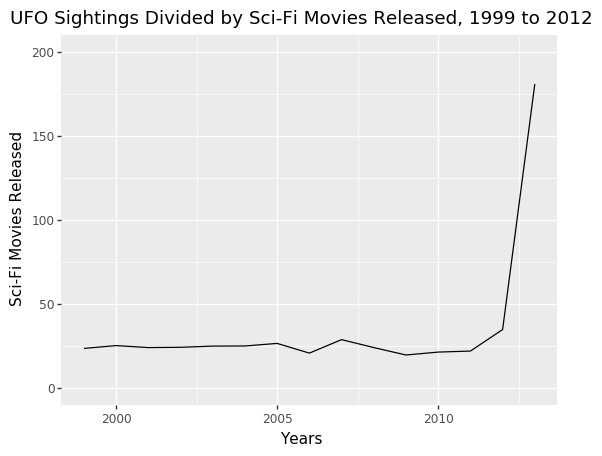

<ggplot: (-9223372029297500770)>

In [80]:
(ggplot(movie_ufo_counts, aes(y = 'ufos_by_movies', x = 'year'))+geom_line()+labs(title = "UFO Sightings Divided by Sci-Fi Movies Released, 1999 to 2012", y = "Sci-Fi Movies Released", x = 'Years')+ylim(0,200))
# Why is there such a low number in 2013? 
# Looking into it, theres just not that many released. Normal data. 




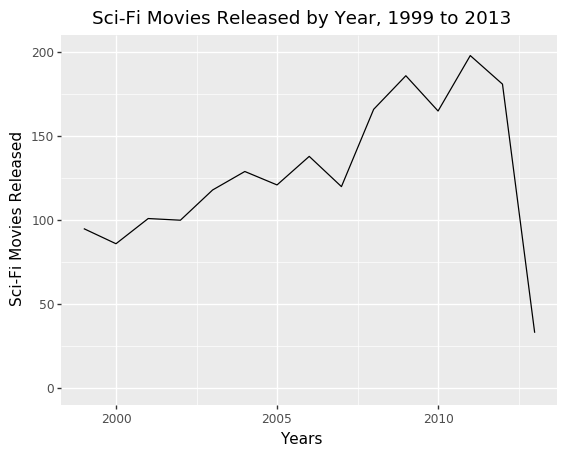

<ggplot: (7559919680)>

In [92]:
(ggplot(movie_ufo_counts, aes(y = 'scifi_movie_counts', x = 'year'))+geom_line()+labs(title = "Sci-Fi Movies Released by Year, 1999 to 2013", y = "Sci-Fi Movies Released", x = 'Years')+ylim(0,200))





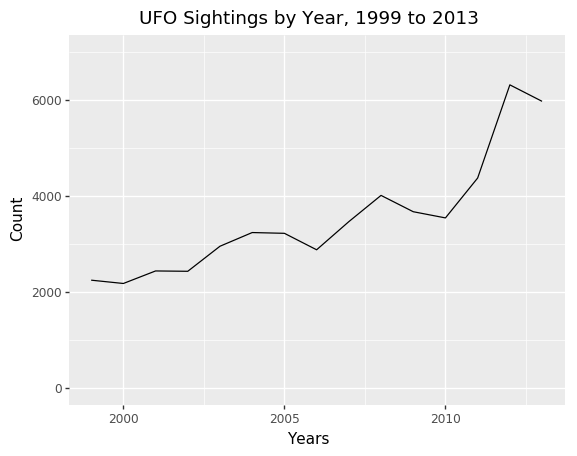

<ggplot: (7562731149)>

In [78]:

(ggplot(ufo_year_counts, aes(y = 'ufo_count', x = 'year'))+geom_line()+labs(title = "UFO Sightings by Year, 1999 to 2013", y = "Count", x = 'Years')+ylim(0,7000))#+ scale_x_discrete(name ="Year", limits=["1999","2000","2001",'2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013']))

 

In [61]:
locations4 = movies_and_ufo[['latitude', 'longitude']]
locationlist4 = locations4.values.tolist()
labels4 = movies_and_ufo['shape'].values.astype(str).tolist()
labels_duration4 = movies_and_ufo['duration_hours_mins'].values.astype(str).tolist()
labels_movie_released = movies_and_ufo['movie_released'].values.astype(str).tolist()


In [63]:
# Cluster Map of CA Movies and UFO Sightings.
map5 = folium.Map(location = [38.437574,-121.849776], zoom_start = 9)
marker_cluster = MarkerCluster().add_to(map5)

for point in range(0, len(locationlist4)):
    folium.Marker(locationlist4[point], popup = folium.Popup('Shape: '+labels4[point]+', Duration: '+labels_duration4[point]+', Movie Released: '+labels_movie_released[point]),icon=folium.Icon(color='black', icon_color='green', icon='male', angle=0, prefix='fa')).add_to(marker_cluster)

#map5
# Map won't show up


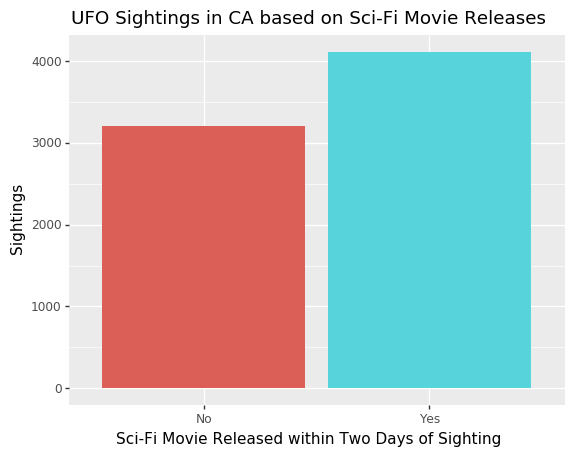

<ggplot: (7547617905)>

In [64]:
(ggplot(movies_and_ufo, aes(x = 'movie_released',fill = 'movie_released'))+geom_bar(position = position_dodge(width = 0.9))+labs(title = "UFO Sightings in CA based on Sci-Fi Movie Releases", y = "Sightings", x = 'Sci-Fi Movie Released within Two Days of Sighting',fill = "Sci-Fi Movie Opening Weekend")+ guides(fill = False))
# Durations are longer for when a sci-fi movie has been released lately.
 

There have been lots of Science Fiction (Sci-Fi) movies over the years solely based on the possibility of extraterrestrial life. As such, we became interested in the possibility of a correlation between the release of Sci-Fi movies and reported UFO sightings. Using an API, we obtained and cleaned data about Sci-Fi movies in our 14 year time period from The Movie Database. The two line charts above detail the number of Sci-Fi movies released between 1999 and 2013 as well as the number of reported UFO sightings per year in that same time range. From the graphs, we can see that over the 14 year time period there was an increase in both the number of Sci-Fi movies released every year and reported UFO sightings every year. There is an anomaly in the Sci-Fi Movie releases in 2013, where there was a huge decrease in the release of movies that year.

The above bar chart, ‘UFO Sightings in CA based on Sci-Fi Movie Releases’, shows whether or not a Sci-Fi movie was released within two days of a reported UFO sighting in California. The graph informs us that there is a slightly greater amount of sightings reported within two days of a movie release than not. However, it is important to note that each year there were between 100 and 200 Sci-Fi movie releases. This huge amount of movies means that there is a high probability that a reported UFO sighting happened to coincide with a movie release day. Regardless, we see a correlation between the two (which does not imply causation), and as CGI/special effects continue to improve perhaps people will have a harder time telling fact from fiction. 


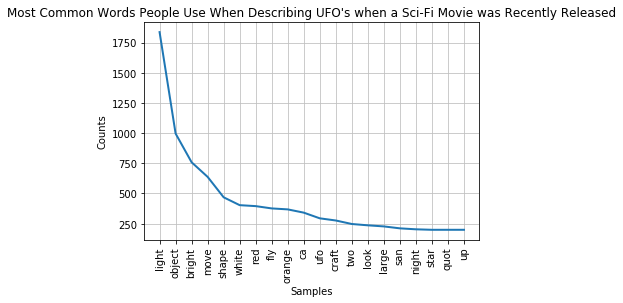

In [65]:
# Yes movies
text_shape = yes_movie.loc[:,'comments']
text_shape = text_shape.str.cat(sep=', ')

shape_words = nltk.word_tokenize(text_shape.lower())
shape_words

shape_tags = nltk.pos_tag(shape_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in shape_tags]


stopwords = nltk.corpus.stopwords.words("english")
stopwords = [stopwords,'44','39','i','a','and','of','to','at','the','then','in','be','it','over','on','fly,','my','with','from','see','saw','very','that','like','for','sky']
words_cont = [w for w in words if w not in stopwords]
fq = nltk.FreqDist(w for w in words_cont if w.isalnum())

fq.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO's when a Sci-Fi Movie was Recently Released")


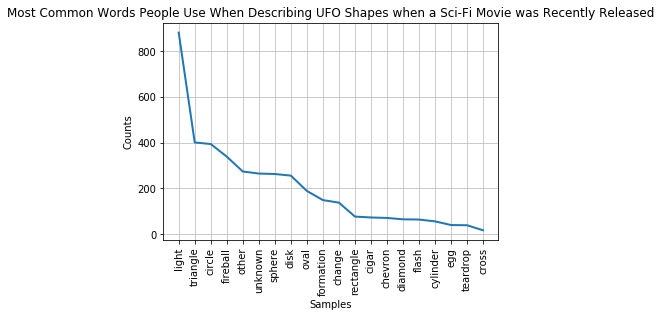

In [66]:
# Yes movies
text_shape = yes_movie.loc[:,'shape']
text_shape = text_shape.str.cat(sep=', ')

shape_words = nltk.word_tokenize(text_shape.lower())
shape_words

shape_tags = nltk.pos_tag(shape_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in shape_tags]


stopwords = nltk.corpus.stopwords.words("english")
stopwords = [stopwords,'44','39','i','a','and','of','to','at','the','then','in','be','it','over','on','fly,','my','with','from','see','saw','very','that','like','for','sky']
words_cont = [w for w in words if w not in stopwords]
fq = nltk.FreqDist(w for w in words_cont if w.isalnum())

fq.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO Shapes when a Sci-Fi Movie was Recently Released")


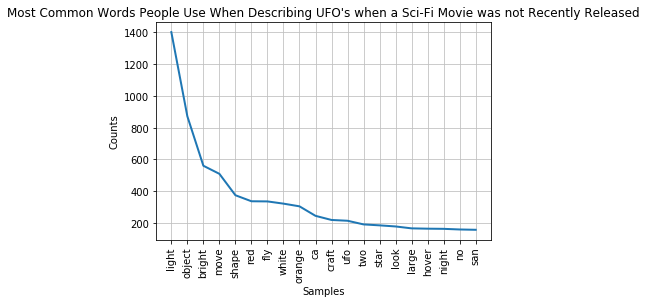

In [67]:
# No movies
text_shape = no_movie.loc[:,'comments']
text_shape = text_shape.str.cat(sep=', ')

shape_words = nltk.word_tokenize(text_shape.lower())
shape_words

shape_tags = nltk.pos_tag(shape_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in shape_tags]


stopwords = nltk.corpus.stopwords.words("english")
stopwords = [stopwords,'44','39','i','a','and','of','to','at','the','then','in','be','it','over','on','fly,','my','with','from','see','saw','very','that','like','for','sky']
words_cont = [w for w in words if w not in stopwords]
fq = nltk.FreqDist(w for w in words_cont if w.isalnum())

fq.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO's when a Sci-Fi Movie was not Recently Released")


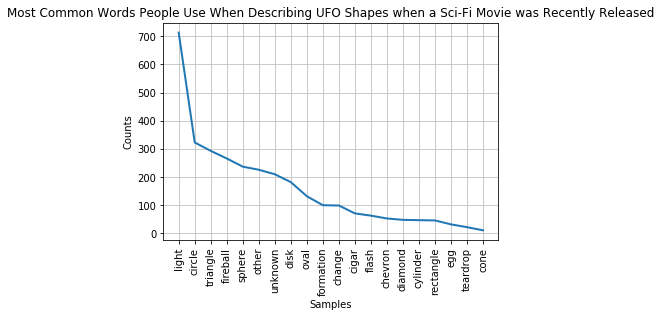

In [68]:
# No movies
text_shape = no_movie.loc[:,'shape']
text_shape = text_shape.str.cat(sep=', ')

shape_words = nltk.word_tokenize(text_shape.lower())
shape_words

shape_tags = nltk.pos_tag(shape_words)
words = [lemmatizer.lemmatize(w,wordnet_pos(t)) for (w,t) in shape_tags]


stopwords = nltk.corpus.stopwords.words("english")
stopwords = [stopwords,'44','39','i','a','and','of','to','at','the','then','in','be','it','over','on','fly,','my','with','from','see','saw','very','that','like','for','sky']
words_cont = [w for w in words if w not in stopwords]
fq = nltk.FreqDist(w for w in words_cont if w.isalnum())

fq.plot(20, cumulative = False, 
                title = "Most Common Words People Use When Describing UFO Shapes when a Sci-Fi Movie was Recently Released")


The two frequency plots for comments are essentially the same for the first couple words. Same for shape. However, the most common words for comments when a sci-fi movie was recently released are 2x as likely to be used compared to when no sci-fi movie was released within several days. 

# Conclusions and Considerations

Overall, our analysis of the UFO data from 1999 to 2013 garnered mixed, yet interesting results. We found that reported UFO sightings are most likely to occur at night, specifically around 10 or 11 pm. We also found that there are certain days that have much more reported UFO sightings, such as New Year’s Day or the 4th of July. One of our speculations for this is that on those two particular days people are out late into the night and typically drink a good amount of alcohol which could impair judgment. 

We also found a high correlation between state populations and how many reported UFO sightings there are per state. The state of Washington was a slight anomaly; however, we believe this could be related to the fact that the National UFO Reporting Center is located in Washington. When we performed a more in-depth analysis of the locations of reported UFO sightings within California we found that in areas with higher densities of people there were also more reported UFO sightings from there as well. 

When we included metrics on binge drinking, opioid prescriptions, urban population, and unemployment rate, we found some slight correlations between drinking, unemployment, and reported sightings. However, we cannot state that there are any direct causal relationships between these metrics without further investigation into confounding variables, possible seasonal trends, and deeper statistical testing.

Our analysis of Science Fiction movie release with reported UFO sightings didn’t produce very fascinating results. About 100-200 Science Fiction movies were released every year so it’s very common for a reported UFO sighting to be within a two-day range of a movie release date. We did notice that reported durations for UFO sightings increased on average if a sci-fi movie was released recently. 

We performed word frequency analyses on the comments and shapes categories of the UFO data set to see if there were any trends with words people were using to describe their reported UFO sightings. Some of the most popular words people used in comments to describe their reported UFO encounter dealt with words surrounding light (bright, light, red, orange). A common word also found in the comments section was ufo. Some of the most common words used in shapes were triangle, disk, fireball, sphere, cigar, and egg. 

Overall, our analysis of the data provided interesting conclusions, but simultaneously raised more questions of the relationships between reported sightings, human, and environmental elements that could be affecting the observations.
